# jobflow

The Python package `jobflow` was developed in the context of the Materials Project and its overall flexibility allows for building workflows that go beyond the usage in material science. `jobflow` forms the basis of `atomate2`, a software package for data generation workflows. `jobflow` and `atomate2` are key packages of the Materials Project. `jobflow` was especially designed to simplify the execution of dynamic workflows -- when the actual number of jobs is dynamically determined upon runtime instead of being statically fixed before running the workflow(s).

## Installation / Setup
`jobflow` can be installed via ‘pip install‘ and directly run with the default setup. It will then internally rely on a predefined database which is currently a memory database as defined in the software package `maggma`. For large-scale usage, a MongoDB-like database might be specified for each project in a jobflow.yaml file.
A high-throughput setup (i.e., parallel execution of independent parts in the workflow) of `jobflow` can be achieved using additional packages like [`fireworks`](https://materialsproject.github.io/fireworks/) or [`jobflow-remote`](https://matgenix.github.io/jobflow-remote/). Both packages require a MongoDB database. In case of `FireWorks`, however, the MongoDB database needs to be connected to the compute nodes. `jobflow-remote` allows remote submission options that only require a MongoDB database on the submitting computer but not the compute nodes. It can also deal with multi-factor authentification.

## Basic introduction to `jobflow` concepts
Before diving into more details, we need to discuss the core concepts of `jobflow`, which is written in Python. It defines `job` and `Flow` objects to handle the correct sequential execution of a workflow. A `job` is a class that allows for the delayed execution of a function. Functions can be easily transformed into a `job` with the `@job` decorator, as demonstrated here with a test function:

In [1]:
from jobflow import job
@job
def my_function(my_parameter: int):
    return my_parameter

job1 = my_function(my_parameter=1)


When we connect several `jobs` to generate a `Flow` object, we can construct a whole workflow. The list of connected `jobs` has to be passed to initialize a `Flow`. The order of the `jobs` is automatically determined by the job connectivity via the `job.output` upon runtime. We can also connect several `jobs` and `Flows` to create a new `Flow`.


In [ ]:
from jobflow import job, Flow
@job
def my_function(my_parameter: int):
    return my_parameter
@job
def my_second_function(my_parameter: int):
    return my_parameter

job1 = my_function(my_parameter=1)
job2 = my_second_function(job1.output)
flow = Flow([job1, job2], job2.output)

The `Maker` object further simplifies the implementation of `job` and `Flow` objects. It is an extended dataclass object that generates a `job` or `Flow` with the `make` method. Dataclasses are used as they allow to define immutable default values. These `Makers` can then be used to reuse code via the usual inheritance in Python.


In [3]:
from dataclasses import dataclass
from jobflow import Maker
@dataclass
class MyMaker(Maker):
    name: str = "My Maker"
    scaling: float = 1.1

    @job
    def make(self, my_parameter: int):
        return my_parameter * self.scaling
    
@dataclass
class MyInheritedMaker(MyMaker):
    name: str = "My inherited Maker"

job1=MyMaker().make(my_parameter=1)

When faced with dynamic workflows, where the number of jobs is unclear before execution, a `Response` object instead of a `job` or `Flow` object can be returned. There are several options to insert the new list of jobs into the `Response` object.
We will now use this knowledge to implement the Quantum Espresso-related tasks for calculating a "Energy vs. Volume" curve. It’s important to point out that this is only a basic implementation, and further extensions towards data validation or for nicer user experience can be added. 

> ℹ️ Note: all outputs of a job need to be transformable into a JSON-like format. Therefore, we use a pymatgen `Structure` object here instead of an ase `Atoms` object. `Structure` inherits from the Python package monty’s MSONable class allowing an easy serialization into a `dict`. In addition, commands to execute jobs might be set in such a way that users can easily adapt them in a configuration file.

For building the Quantum Espresso (QE)-related tasks, we start by importing essential tools to be able to create and navigate directories (`os`) and execute programs like the QE binary (`subprocess`). `pydantic` is very convenient for managing all kinds of data types.

In [7]:
import subprocess
import os
from pydantic import BaseModel, Field

Then we import tools for data plotting and mathematical operations and manipulation.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

ASE provides us with a method to create bulk crystal systems and a writer to handle output. 

In [3]:
from ase.build import bulk
from ase.io import write

From ADIS we take the QE XML output parser.

In [4]:
from adis_tools.parsers import parse_pw

As we want to caculate a (E, V) curve with QE, we start by implementing a function to apply a certain strain to the original structure.

In [4]:
def generate_structures(structure, strain_lst):  # structure should be of ase Atoms type
    structure_lst = []
    for strain in strain_lst:
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain**(1/3), 
            scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return structure_lst

Then we define a function to plot and save the (E, V) curve as a PNG file.

In [6]:
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

Next, we need a function to write the QE input files. The `input_dict` has to contain all essential input information like the structure, the pseudopotentials, the number of kpoints, the calculation type and the smearing type.

In [7]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'input.pwi')
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data={
            'calculation': input_dict["calculation"],
            'occupations': 'smearing',
            'degauss': input_dict["smearing"],
        }, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

Then, we also need to define a function to collect the output from the QE calculation to pass it to `plot_energy_volume_curve` in order to plot the actual figure. Here we make use of the ADIS QE XML output parser.

In [8]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, 'pwscf.xml'))
    return {
        "structure": output['ase_structure'],
        "energy": output["energy"],
        "volume": output['ase_structure'].get_volume(),
    }

Now, we want to be able to systematically handle the QE input. We make use of the pymatgen `InputSet` and `InputGenerator` classes to control and define the input data format. The `QEInputSet` defines the input information format which will be followed by the `QEInputGenerator`. We also define an extra `QEInputStaticGenerator` class (inheriting from `QEInputGenerator`) to be able to separately handle the static QE calculations for every strained structure in a convenient way.  Finally, we define the function `write_qe_input_set` to write the QE input files into the current working directory.

In [5]:
from pymatgen.io.core import InputSet, InputGenerator
from dataclasses import dataclass, field


class QEInputSet(InputSet):
    """
    Writes an QE input based on an input_dict
    """
    def __init__(self, input_dict):
        self.input_dict = input_dict

    def write_input(self, working_directory="."):
        write_input(self.input_dict, working_directory=working_directory)


@dataclass
class QEInputGenerator(InputGenerator):
    """
    Generates an QE input based on the format given in QEInputSet.
    """
    pseudopotentials: dict = field(default_factory=lambda: {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
    kpts: tuple = (3,3,3)
    calculation: str = "vc-relax"
    smearing: float = 0.02
    

    def get_input_set(self, structure) -> QEInputSet:

        input_dict={"structure":structure,
            "pseudopotentials":self.pseudopotentials, 
            "kpts": self.kpts,
            "calculation": self.calculation,
            "smearing": self.smearing,
                    }
        return QEInputSet(input_dict=input_dict)

@dataclass
class QEInputStaticGenerator(QEInputGenerator):
    calculation: str = "scf"

   
def write_qe_input_set(structure, input_set_generator=QEInputGenerator(), working_directory="."):
    qis = input_set_generator.get_input_set(structure=structure)
    qis.write_input(working_directory=working_directory)
    
    

The next steps are all concerned about handling the execution of QE and the output data collection. We start by defining a QE task document `QETaskDoc` to systematically collect the output data. For the (E, V) curve, the energy and volume are of course the most important information. The task document could be further extended to contain information that is relevant for other purposes. Next, we define a `BaseQEMaker` to handle generic QE jobs (in our case for the structural relaxation) and a separate `StaticQEMaker` for the static QE calculations. The `BaseQEMaker` is expecting the generic input set generated by `QEInputGenerator`, while `StaticQEMaker` expects the `QEInputStaticGenerator` type. As the `StaticQEMaker` inherits from the `BaseQEMaker`, we only need to make sure to pass the correct input set generator type.

In [8]:
from dataclasses import dataclass, field
from jobflow import job, Maker
from pymatgen.io.ase import MSONAtoms
from typing import Any, Optional, Union


QE_CMD= "mpirun -np 1 pw.x -in input.pwi > output.pwo"
def run_qe(qe_cmd=QE_CMD):
    subprocess.check_output(qe_cmd, shell=True, universal_newlines=True)
    
    
class QETaskDoc(BaseModel):
    structure: Optional[MSONAtoms] = Field(None, description="ASE structure")
    energy: Optional[float] = Field(None, description="DFT energy in eV")
    volume: Optional[float] = Field(None, description="volume in Angstrom^3")
    
    @classmethod
    def from_directory(cls, working_directory):
        output=collect_output(working_directory=working_directory)
        # structure object needs to be serializable, i.e., we need an additional transformation
        return cls(structure=MSONAtoms(output["structure"]), energy=output["energy"], volume=output["volume"])

@dataclass
class BaseQEMaker(Maker):
    """
    Base QE job maker.

    Parameters
    ----------
    name : str
        The job name.
    input_set_generator : .QEInputGenerator
        A generator used to make the input set.
    """

    name: str = "base qe job"
    input_set_generator: QEInputGenerator = field(default_factory=QEInputGenerator)

    @job(output_schema=QETaskDoc)
    def make(
        self, structure
    ) -> QETaskDoc:
        """
        Run a QE calculation.

        Parameters
        ----------
        structure : MSONAtoms|Atoms
            An Atoms or MSONAtoms object.
            
        Returns
        -------
            Output of a QE calculation
        """
        # copy previous inputs

        # write qe input files
        write_qe_input_set(
            structure=structure, input_set_generator=self.input_set_generator)

        # run the QE software
        run_qe()

        # parse QE outputs in form of a task document
        task_doc=QETaskDoc.from_directory(".")
        
        return task_doc

@dataclass
class StaticQEMaker(BaseQEMaker):
    """
    Base QE job maker.

    Parameters
    ----------
    name : str
        The job name.
    input_set_generator : .QEInputGenerator
        A generator used to make the input set.
    """

    name: str = "static qe job"
    input_set_generator: QEInputGenerator = field(default_factory=QEInputStaticGenerator)


Finally, it's time to orchestrate all functions and classes together in an actual flow. Note how the number of jobs in `get_ev_curve` can be flexibly controlled by using `strain_lst` and therefore we use `Response` to handle the job output. By making `get_ev_curve` and `plot_energy_volume_curve_job` into `job` objects using the `@job` decorator, we ensure that first all the (E, V) data points are calculated before they are plotted. The `qe_flow` contains the list of the jobs that need to be executed in this workflow. The jobs are connected by the respective `job.output` objects that also ensures the correct order in executing the jobs.

2024-04-04 15:55:32,815 INFO Started executing jobs locally
2024-04-04 15:55:32,892 INFO Starting job - base qe job (72ab2547-8a66-4dd0-a95a-b6255a668cd8)


[jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2d4ksucf2d:00139] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-04-04 15:56:37,395 INFO Finished job - base qe job (72ab2547-8a66-4dd0-a95a-b6255a668cd8)
2024-04-04 15:56:37,396 INFO Starting job - get_ev_curve (87ad6b9b-9f34-463e-b705-1ab7cdcf9aee)
2024-04-04 15:56:37,404 INFO Finished job - get_ev_curve (87ad6b9b-9f34-463e-b705-1ab7cdcf9aee)
2024-04-04 15:56:37,406 INFO Starting job - static qe job (b0759785-155b-4e79-9b72-c626067d81e1)


[jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2d4ksucf2d:00149] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2024-04-04 15:56:45,563 INFO Finished job - static qe job (b0759785-155b-4e79-9b72-c626067d81e1)
2024-04-04 15:56:45,564 INFO Starting job - static qe job (514079e9-d6ae-4369-8b80-bf8ca7860540)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2d4ksucf2d:00159] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-04-04 15:56:53,979 INFO Finished job - static qe job (514079e9-d6ae-4369-8b80-bf8ca7860540)
2024-04-04 15:56:53,980 INFO Starting job - static qe job (6e3c5a28-4edb-4244-9e35-0b8733b946c4)


[jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2d4ksucf2d:00169] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2024-04-04 15:57:03,600 INFO Finished job - static qe job (6e3c5a28-4edb-4244-9e35-0b8733b946c4)
2024-04-04 15:57:03,600 INFO Starting job - static qe job (980b72a5-fbea-445c-9075-a880322c8261)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2d4ksucf2d:00179] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2024-04-04 15:57:14,907 INFO Finished job - static qe job (980b72a5-fbea-445c-9075-a880322c8261)
2024-04-04 15:57:14,908 INFO Starting job - static qe job (a44a935f-6bd2-4279-bbcb-53d5ed890a99)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2d4ksucf2d:00189] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-04-04 15:57:27,174 INFO Finished job - static qe job (a44a935f-6bd2-4279-bbcb-53d5ed890a99)
2024-04-04 15:57:27,174 INFO Starting job - store_inputs (87ad6b9b-9f34-463e-b705-1ab7cdcf9aee, 2)
2024-04-04 15:57:27,176 INFO Finished job - store_inputs (87ad6b9b-9f34-463e-b705-1ab7cdcf9aee, 2)
2024-04-04 15:57:27,176 INFO Starting job - plot_energy_volume_curve_job (9987ab9f-1ae9-4172-8e31-b2c9920d4791)
2024-04-04 15:57:27,256 INFO Finished job - plot_energy_volume_curve_job (9987ab9f-1ae9-4172-8e31-b2c9920d4791)
2024-04-04 15:57:27,256 INFO Finished executing jobs locally


{'72ab2547-8a66-4dd0-a95a-b6255a668cd8': {1: Response(output=QETaskDoc(structure=MSONAtoms(symbols='Al4', pbc=True, cell=[4.045218941837687, 4.045218941837687, 4.045218941837687]), energy=-1074.9365272693506, volume=66.1951387021735), detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False)},
 '87ad6b9b-9f34-463e-b705-1ab7cdcf9aee': {1: Response(output=None, detour=None, addition=None, replace=Flow(name='Flow', uuid='0e46d480-7699-4e03-889b-b4ba65fe3d38')
  1. Job(name='static qe job', uuid='b0759785-155b-4e79-9b72-c626067d81e1')
  2. Job(name='static qe job', uuid='514079e9-d6ae-4369-8b80-bf8ca7860540')
  3. Job(name='static qe job', uuid='6e3c5a28-4edb-4244-9e35-0b8733b946c4')
  4. Job(name='static qe job', uuid='980b72a5-fbea-445c-9075-a880322c8261')
  5. Job(name='static qe job', uuid='a44a935f-6bd2-4279-bbcb-53d5ed890a99')
  6. Job(name='store_inputs', uuid='87ad6b9b-9f34-463e-b705-1ab7cdcf9aee'), stored_data=None, stop_children=False, s

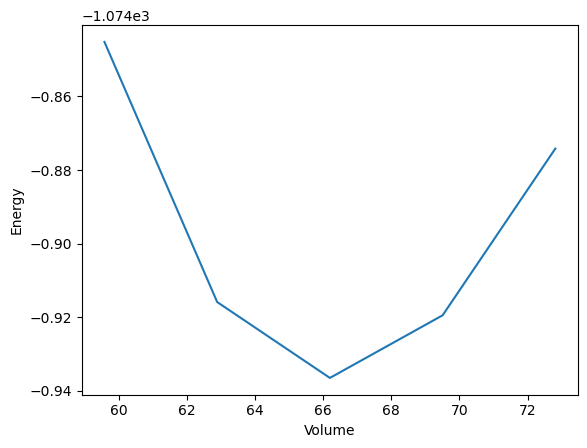

In [10]:
from jobflow import job, Response, Flow, run_locally

@job
def get_ev_curve(structure, strain_lst):
    structures=generate_structures(structure,strain_lst=strain_lst)
    jobs = []
    volumes = []
    energies = []
    for istructure in range(len(strain_lst)):
        new_job = StaticQEMaker().make(structures[istructure])
        jobs.append(new_job)
        volumes.append(new_job.output.volume)
        energies.append(new_job.output.energy)
    return Response(replace=Flow(jobs, output={"energies": energies, "volumes": volumes}))
    
@job
def plot_energy_volume_curve_job(volume_lst, energy_lst):
    plot_energy_volume_curve(volume_lst=volume_lst, energy_lst=energy_lst)

structure = bulk('Al', a=4.15, cubic=True)
relax = BaseQEMaker().make(structure=MSONAtoms(structure))
ev_curve_data = get_ev_curve(relax.output.structure, strain_lst=np.linspace(0.9, 1.1, 5))
# structure optimization job and (E, V) curve data job connected via relax.output
plot_curve = plot_energy_volume_curve_job(volume_lst=ev_curve_data.output["volumes"], energy_lst=ev_curve_data.output["energies"])
# (E, V) curve data job and plotting the curve job connected via ev_curve_data.output
qe_flow = [relax, ev_curve_data, plot_curve]  
# qe_flow is the QE flow that consists of the job for structural optimization, calculating the (E, V) curve data points and plotting the curve
run_locally(Flow(qe_flow), create_folders=True)  # order of the jobs in the flow is determined by connectivity

## Submission to an HPC / Check pointing / Error handling
* `jobflow`: has the command `run_locally` to run jobs in serial with a simple job script
* `fireworks` and `jobflow-remote` exist to simplify and parallelize the submission of jobs, and they allow for checkpointing
* error handling can be implemented but is not directly handled by `jobflow`, e.g. currently in `atomate2`, it is handled by `custodian`

## Data Storage / Data Sharing
Key data can be saved in a dedicated MongoDB-like database. This data can be validated with the help of
`pydantic`. The latter also allows a direct connection to Fast-API. The Materials Project data generation
relies on similar features. Direct calculation outputs will be saved on the machine where the job has been
run. There are no dedicated mechanisms to save whole projects. The database can, however, be used to
accomplish this.

## Publication of the workflow
The `jobflow` infrastructure does not provide a dedicated platform for publishing a workflow currently. However, workflows related to computational materials science have been collected in the pacakge `atomate2`. In addition, users can build their own package by relying on jobflow and share it as any Python project.